In [2]:
import numpy as np
import matplotlib.pyplot as plt

STATES=[0,1,2,3]
ACTIONS=[0,1] #left,right

def step(s,a):
    
    if s==0 or s==2:
        if a==1:
            s_=s+1
        else:
            s_=max(0,s-1)
    else: #s==1
        if a==1:
            s_=s-1
        else:
            s_=s+1
            
    if s_==3:
        return s_,0,True
    else:
        return s_,-1,False
            
START=0

s=START

step(0,0)

(0, -1, False)

In [3]:
step(0,1)

(1, -1, False)

In [4]:
step(1,0)

(2, -1, False)

In [5]:
step(1,1)

(0, -1, False)

In [6]:
step(2,0)

(1, -1, False)

In [7]:
step(2,1)

(3, 0, True)

In [9]:
def true_value(p):
    """ True value of the first state
    Args:
        p (float): probability of the action 'right'.
    Returns:
        True value of the first state.
        The expression is obtained by manually solving the easy linear system
        of Bellman equations using known dynamics.
    """
    return (2 * p - 4) / (p * (1 - p))

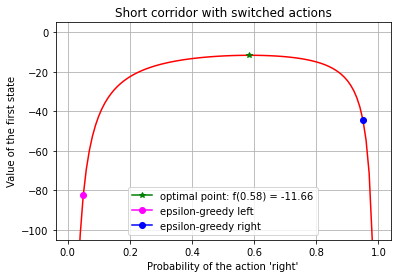

In [11]:

epsilon = 0.05
fig, ax = plt.subplots(1, 1)

# Plot a graph
p = np.linspace(0.01, 0.99, 100)
y = true_value(p)
ax.plot(p, y, color='red')

# Find a maximum point, can also be done analytically by taking a derivative
imax = np.argmax(y)
pmax = p[imax]
ymax = y[imax]
ax.plot(pmax, ymax, color='green', marker="*", label="optimal point: f({0:.2f}) = {1:.2f}".format(pmax, ymax))

# Plot points of two epsilon-greedy policies
ax.plot(epsilon, true_value(epsilon), color='magenta', marker="o", label="epsilon-greedy left")
ax.plot(1 - epsilon, true_value(1 - epsilon), color='blue', marker="o", label="epsilon-greedy right")

ax.set_ylabel("Value of the first state")
ax.set_xlabel("Probability of the action 'right'")
ax.set_title("Short corridor with switched actions")
ax.set_ylim(ymin=-105.0, ymax=5)
ax.legend()
ax.grid()